# Clase 24: Análisis Multivariado II

Para abrir en Google Colab: <a target="_blank" href="https://githubtocolab.com/SysBioengLab/IIQ3402-Statistical-Design/blob/main/Clases/Clase24_AnalisisMultivariadoII.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# Requerimientos
!pip install seaborn -q # Para visualización y datasets
!pip install scipy -q # Para analísis estadísticos
!pip install numpy -q # Para cálculos científicos
!pip install pandas -q # Para almacenamiento y trabajo con datos
!pip install matplotlib -q # Para visualización
!pip install statsmodels -q # Para analísis estadísticos
!pip install rdatasets -q # datasets de R
!pip install scikit-learn -q # Análisis relacionados a Machine Learning
!pip install pingouin -q # Análisis estadísticos
!pip install pyDOE3 -q # Creación de diseño experimental
!pip install plotly -q # visualizaciónes
!pip install yellowbrick -q # visualizar sklearn
!pip install pca -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.0 MB/s eta 0:00:00


## Caso de Estudio: Análisis de la textura de alimentos de respostería


In [2]:
# Dataset
import pandas as pd
# descargamos el set de datos, la primera columna es el indice del dataframe
food_df = pd.read_csv('https://openmv.net/file/food-texture.csv', index_col=0)
food_df.head()

,Oil,Density,Crispy,Fracture,Hardness
B110,16.5,2955,10,23,97
B136,17.7,2660,14,9,139
B171,16.2,2870,12,17,143
B192,16.7,2920,10,31,95
B225,16.3,2975,11,26,143


[11-06-2025 04:36:59] [scatterd.scatterd] [INFO] Create scatterplot


[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(None,
 <Axes: title={'center': '2 Principal Components explain [86.53%] of the variance'}, xlabel='PC1 (60.6% expl.var)', ylabel='PC2 (25.9% expl.var)'>)

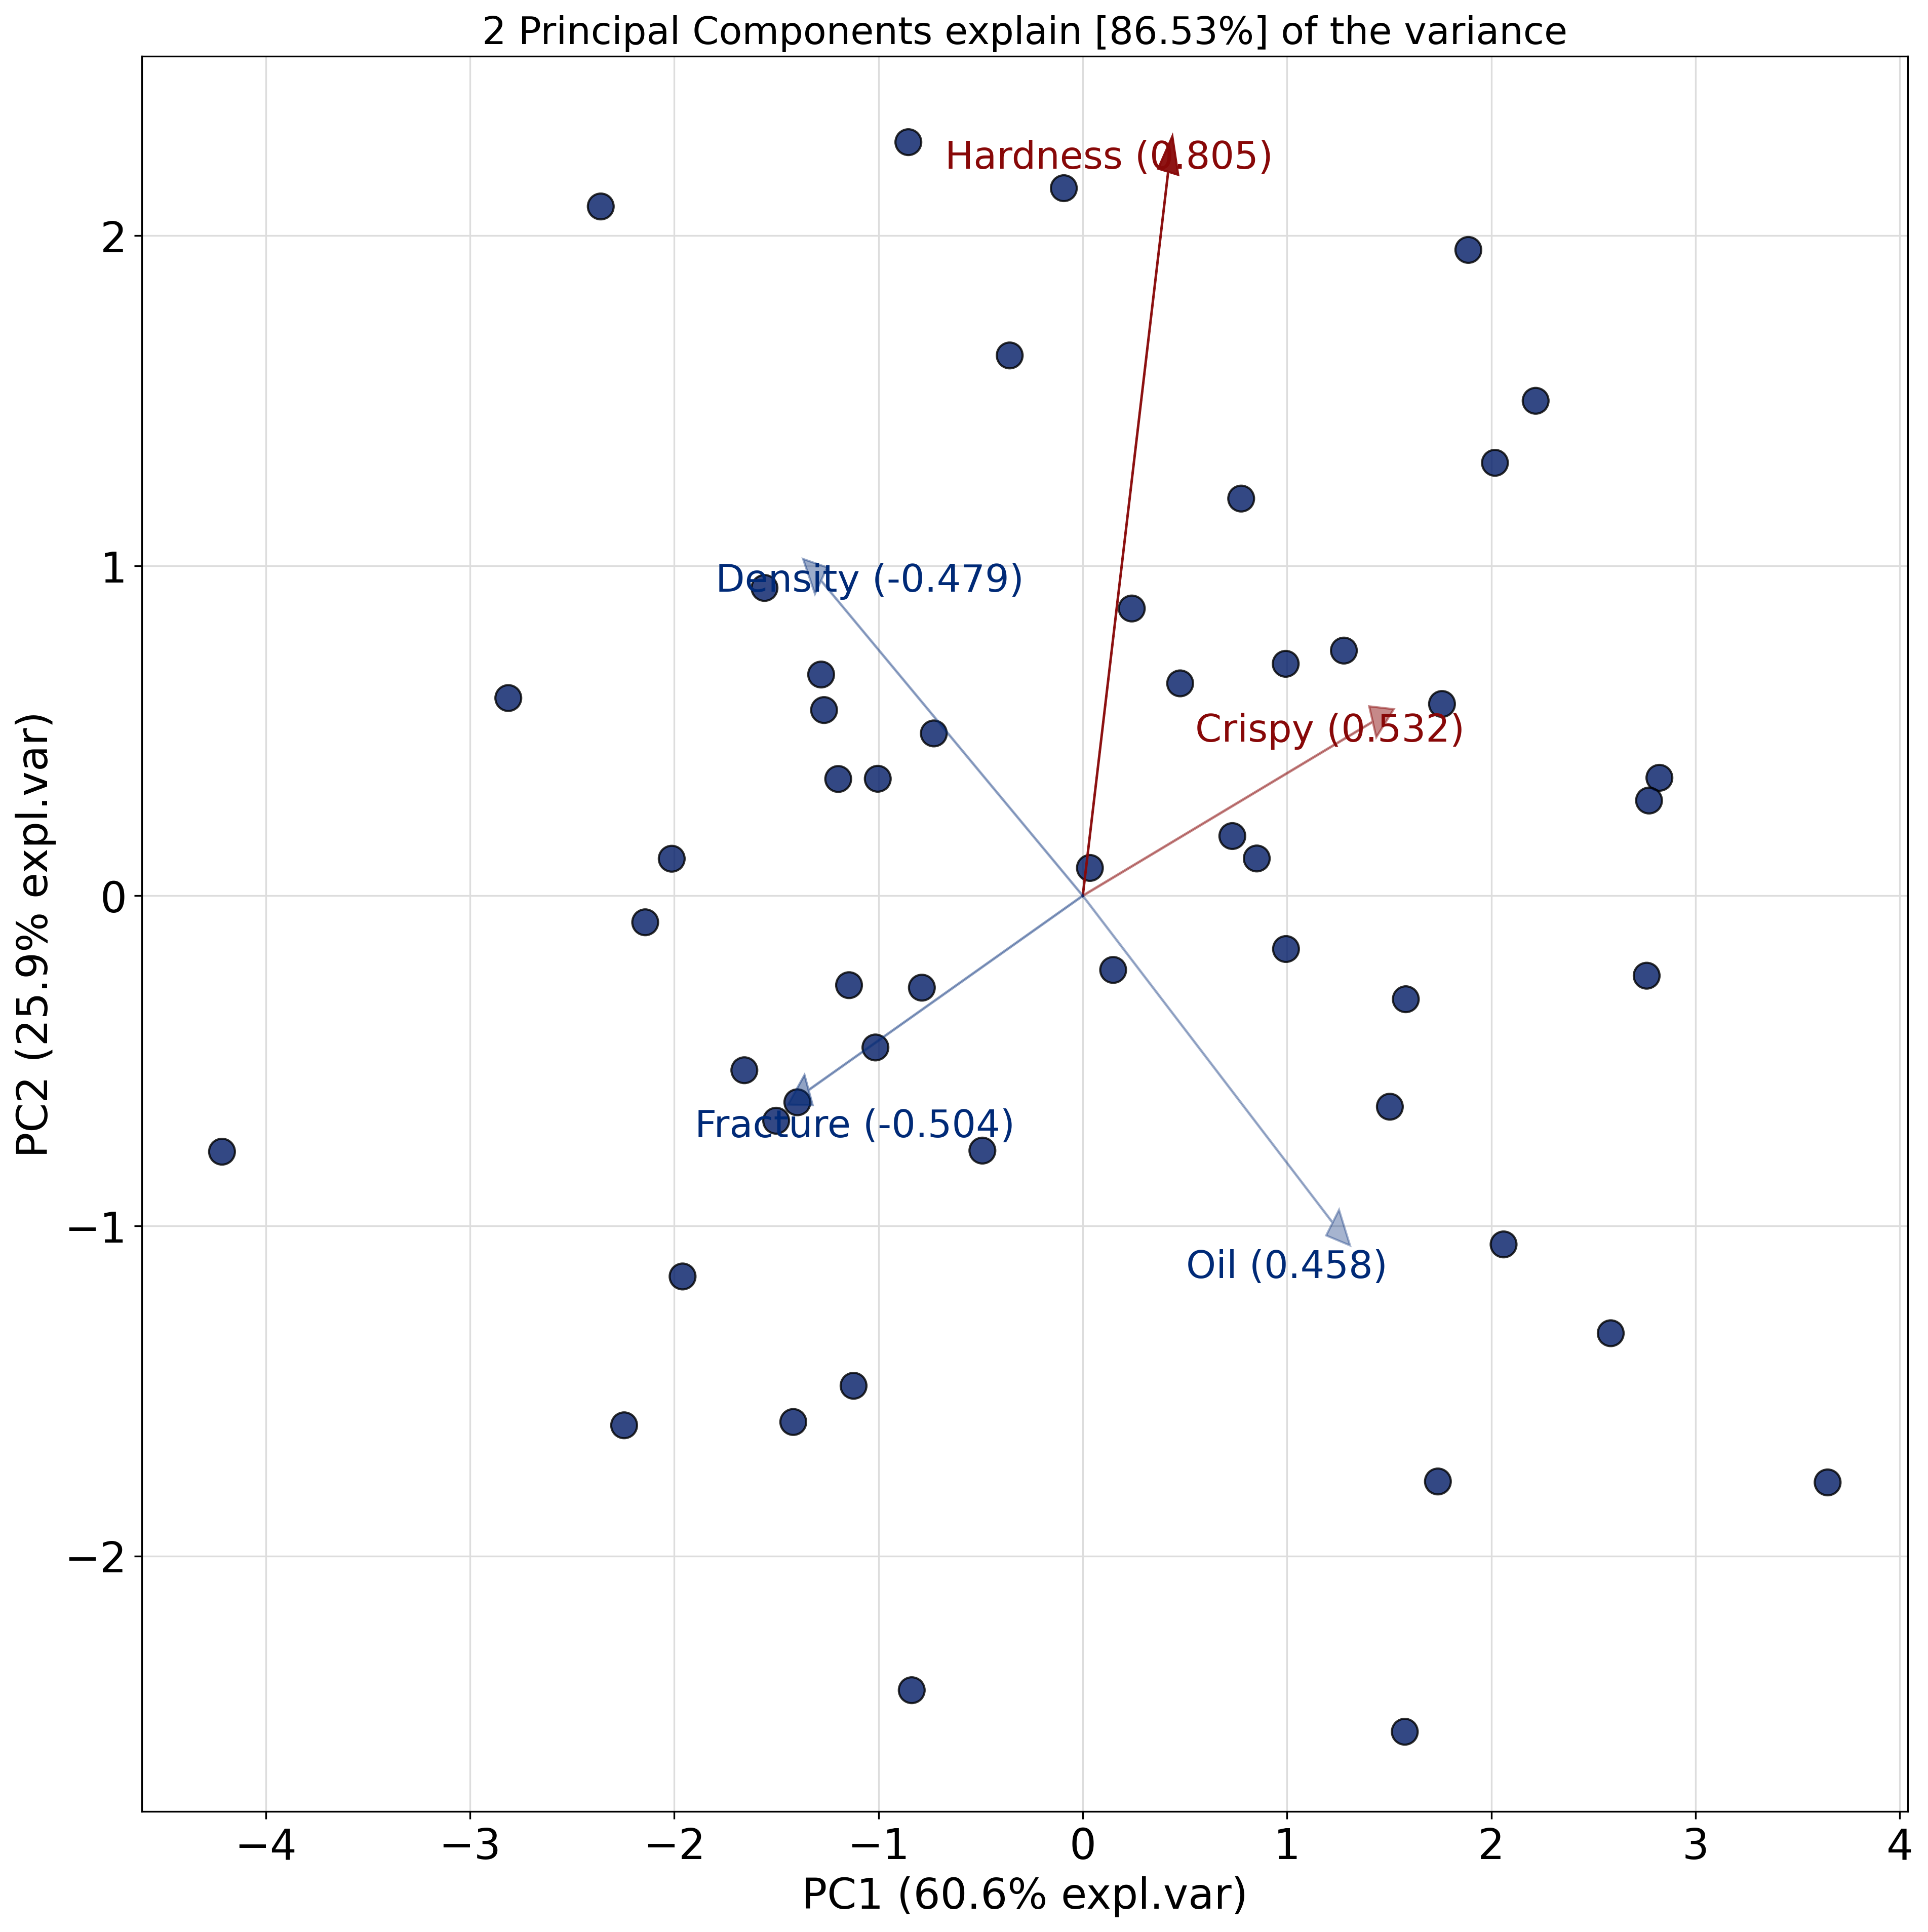

In [44]:
from pca import pca
import matplotlib.pyplot as plt
pca_food_model = pca(n_components=2, normalize = True)
data = pca_food_model.fit_transform(food_df)
fig, ax = plt.subplots(figsize = (15,15), dpi =300)

pca_food_model.biplot(ax = ax)
#PC1>0
ax.fill_betweenx([data['PC']['PC1'].min(),data['PC']['PC1'].max()], -5, 0,
                 alpha = 0.3)
ax.fill_betweenx([data['PC']['PC1'].min(),data['PC']['PC1'].max()], 0, 5,
                 alpha = 0.3)
ax.set_title('')


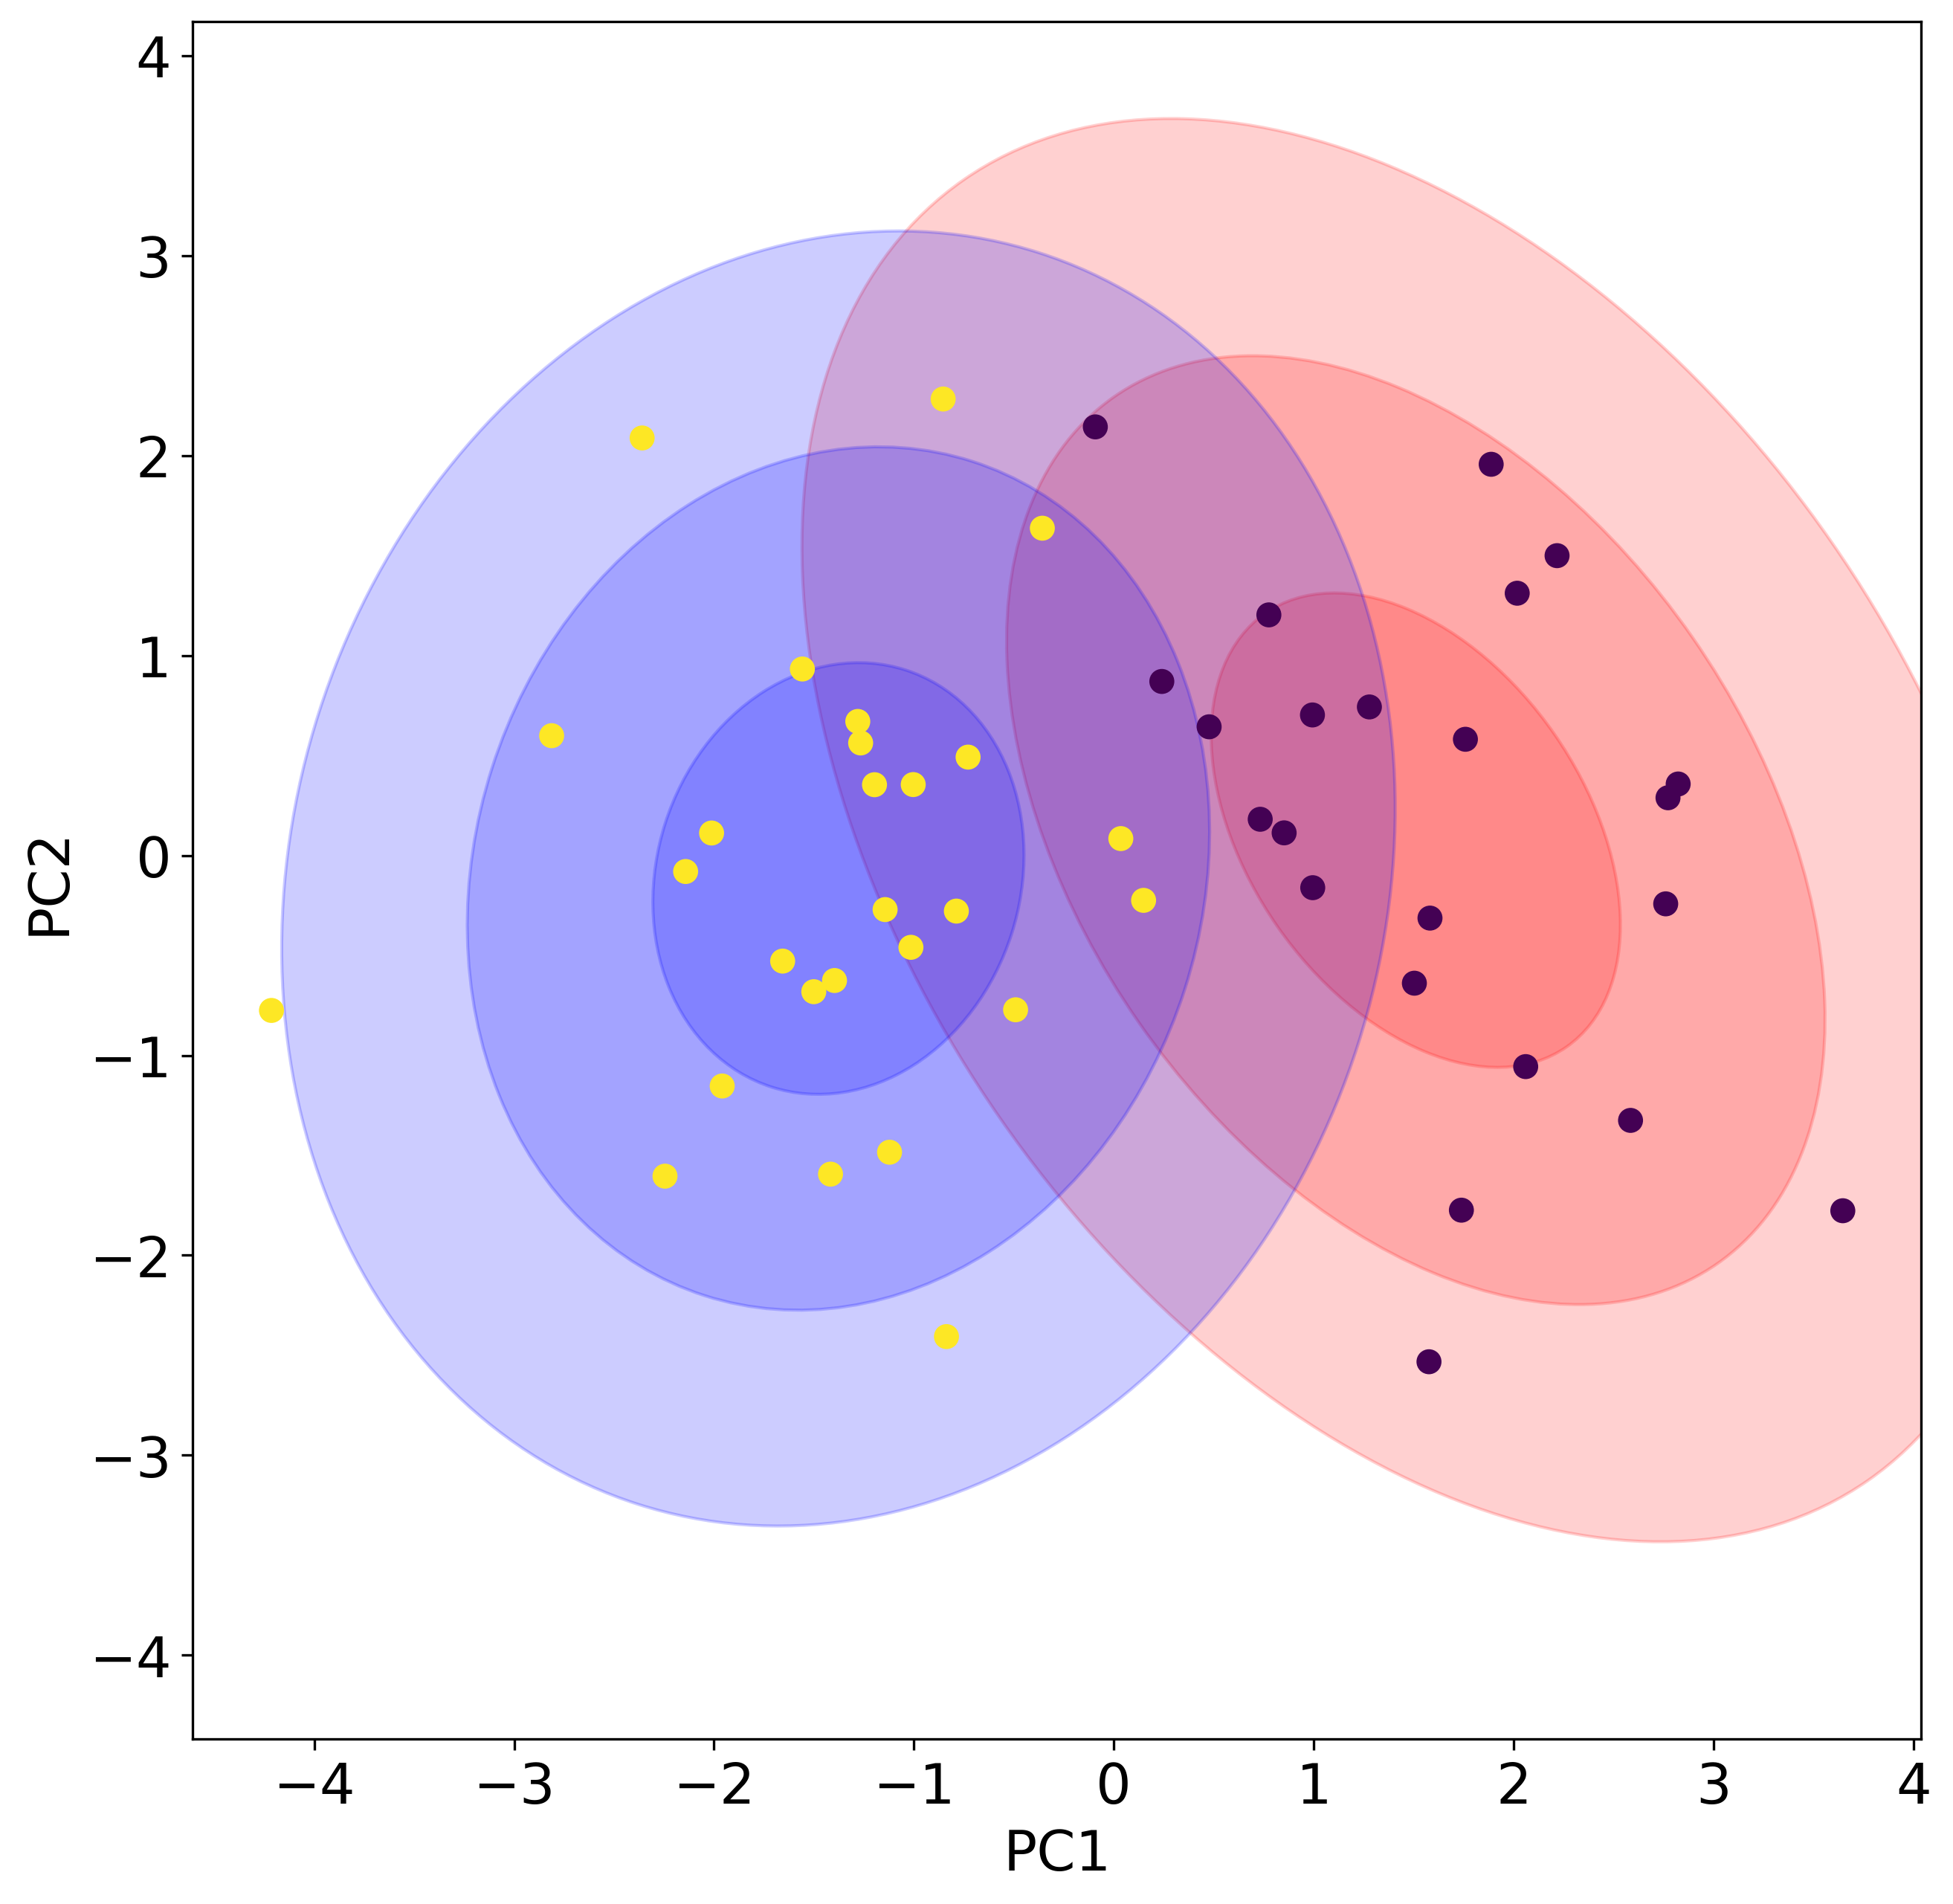

In [43]:

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture
import numpy as np
def plot_gmm(gmm, X, label=True, ax=None, etiquetas = None):
    def draw_ellipse(position, covariance, ax=None, **kwargs):
        ax = ax or plt.gca()

        if covariance.shape == (2, 2):
            U, s, Vt = np.linalg.svd(covariance)
            angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
            width, height = 2 * np.sqrt(s)
        else:
            angle = 0
            width, height = 2 * np.sqrt(covariance)

        for nsig in range(1, 4):
            ax.add_patch(Ellipse(
            xy=position, width=nsig * width, height=nsig * height,
            angle=angle, **kwargs))
    fig, ax = plt.subplots(figsize = (10,10), dpi = 300)
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=50, zorder=2)

    ax.axis('equal')
    w_factor = 0.2 / gmm.weights_.max()
    colors = ['red', 'blue']
    for i, (pos, covar, w) in enumerate(zip(gmm.means_, gmm.covariances_, gmm.weights_)):
        draw_ellipse(pos, covar, ax = ax,alpha=w * w_factor, color = colors[i])
    return fig, ax

gmm = GaussianMixture(n_components=2, random_state=42)
fig, ax = plot_gmm(gmm, data['PC'][['PC1', 'PC2']].values)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()


# Agrupamientos

Además de poder analizar como es que las variables de un set de datos pueden ser reducidos mediante PCA, capturando comportamientos interasantes. Es también posible agrupar los datos mediante diferentes metodologías.

## Agrupamiento Jerárquico

Dado a que tenemos datos númericos, una distancia que es útil es la distancia euclideana, de esta forma podemos calcular las distancias entre los diferentes elementos y agruparlos.

In [48]:
# Estandarizar los datos
from sklearn.preprocessing import StandardScaler
food_standard = pd.DataFrame(
    StandardScaler().fit_transform(food_df),
    columns = food_df.columns, index = food_df.index)
display(food_standard.head())

,Oil,Density,Crispy,Fracture,Hardness
B110,-0.445430,0.790272,-0.864754,0.395481,-1.011854
B136,0.315989,-1.603262,1.410914,-2.191776,0.351131
B171,-0.635784,0.100610,0.273080,-0.713344,0.480939
B192,-0.318527,0.506293,-0.864754,1.873913,-1.076758
B225,-0.572333,0.952546,-0.295837,0.949893,0.480939


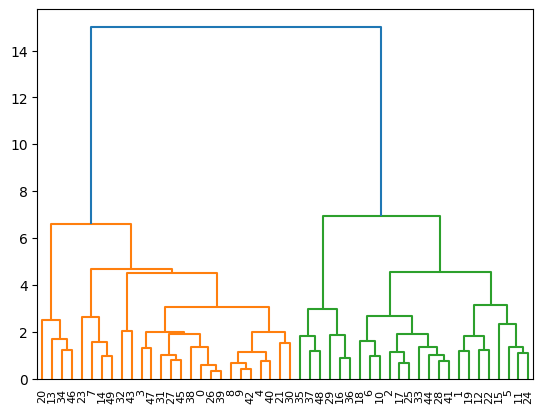

In [92]:
from scipy.cluster import hierarchy

Z = hierarchy.linkage(food_standard, metric = 'euclidean', method='ward')

dendro = hierarchy.dendrogram(Z)
plt.show()

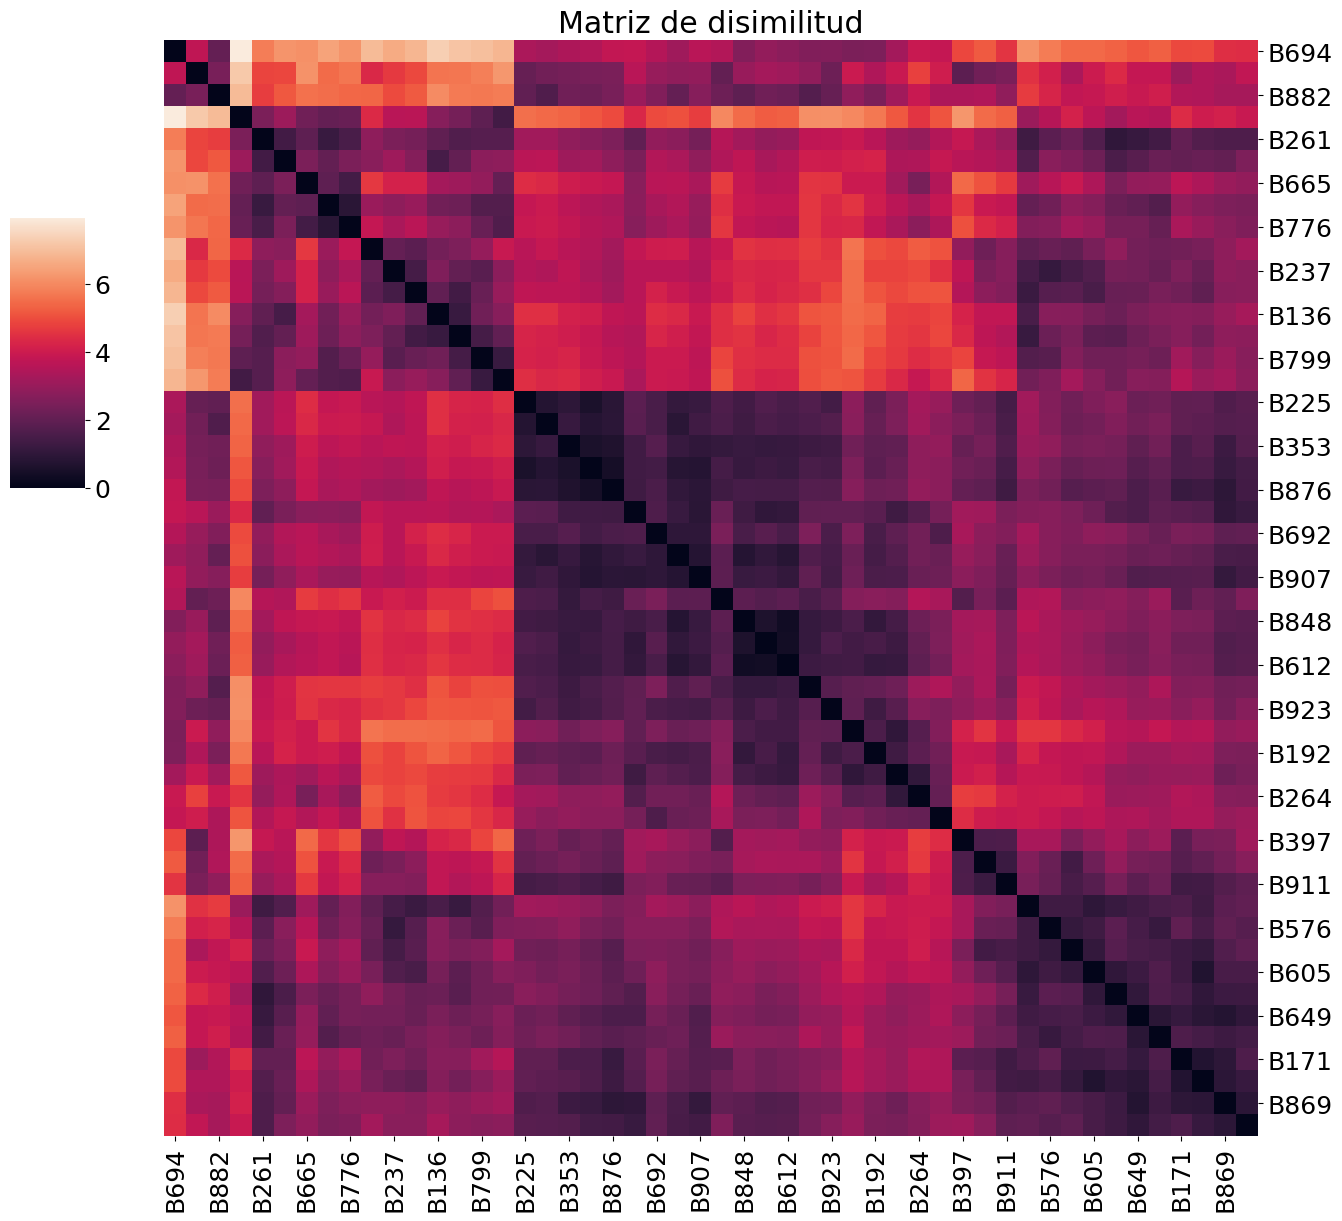

In [69]:
# matriz de disimilitud
from sklearn.metrics import pairwise_distances
import seaborn as sns
distancias = pd.DataFrame(pairwise_distances(food_standard),
                          columns = food_standard.index,
                          index = food_standard.index)
# fig, ax = plt.subplots(dpi = 300, figsize = (10,10))
cluster = sns.clustermap(distancias, figsize = (15,15),
                         cbar_pos=(0.1, 0.5, 0.05, 0.18))


cluster.ax_heatmap.set_xticklabels(cluster.ax_heatmap.get_xmajorticklabels(), rotation = 90)
cluster.ax_heatmap.set_yticklabels(cluster.ax_heatmap.get_ymajorticklabels(), rotation = 0)
cluster.ax_heatmap.set_title('Matriz de disimilitud')
cluster.ax_row_dendrogram.set_visible(False)
cluster.ax_col_dendrogram.set_visible(False)
cluster.savefig('cluster.png', dpi = 600)
plt.show()




Para poder analizar con cuantos grupos es bueno quedarse, se pueden analizar la cantidad de clusters optimos según diferentes criterios. Para esto, utilizamos un modelo desde sklearn y el paquete [yellowbrick](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html)

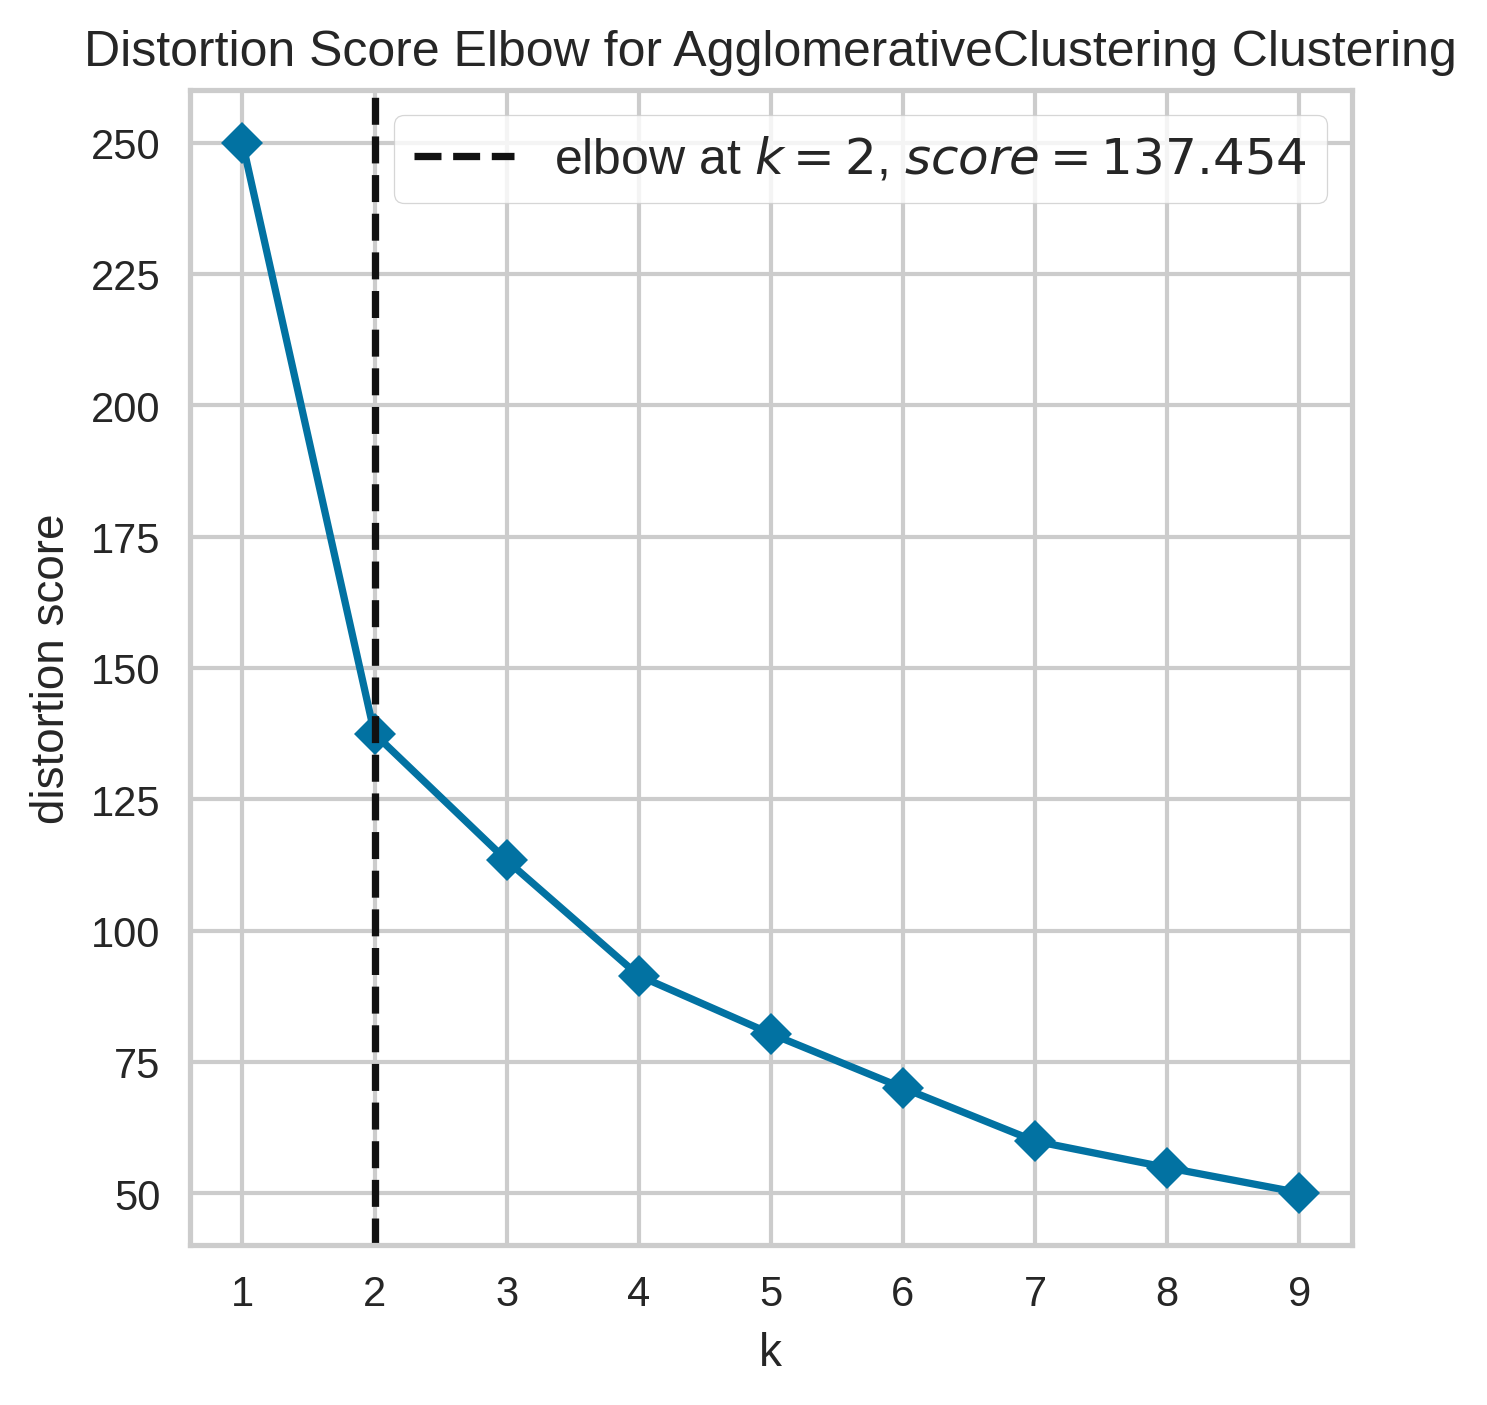

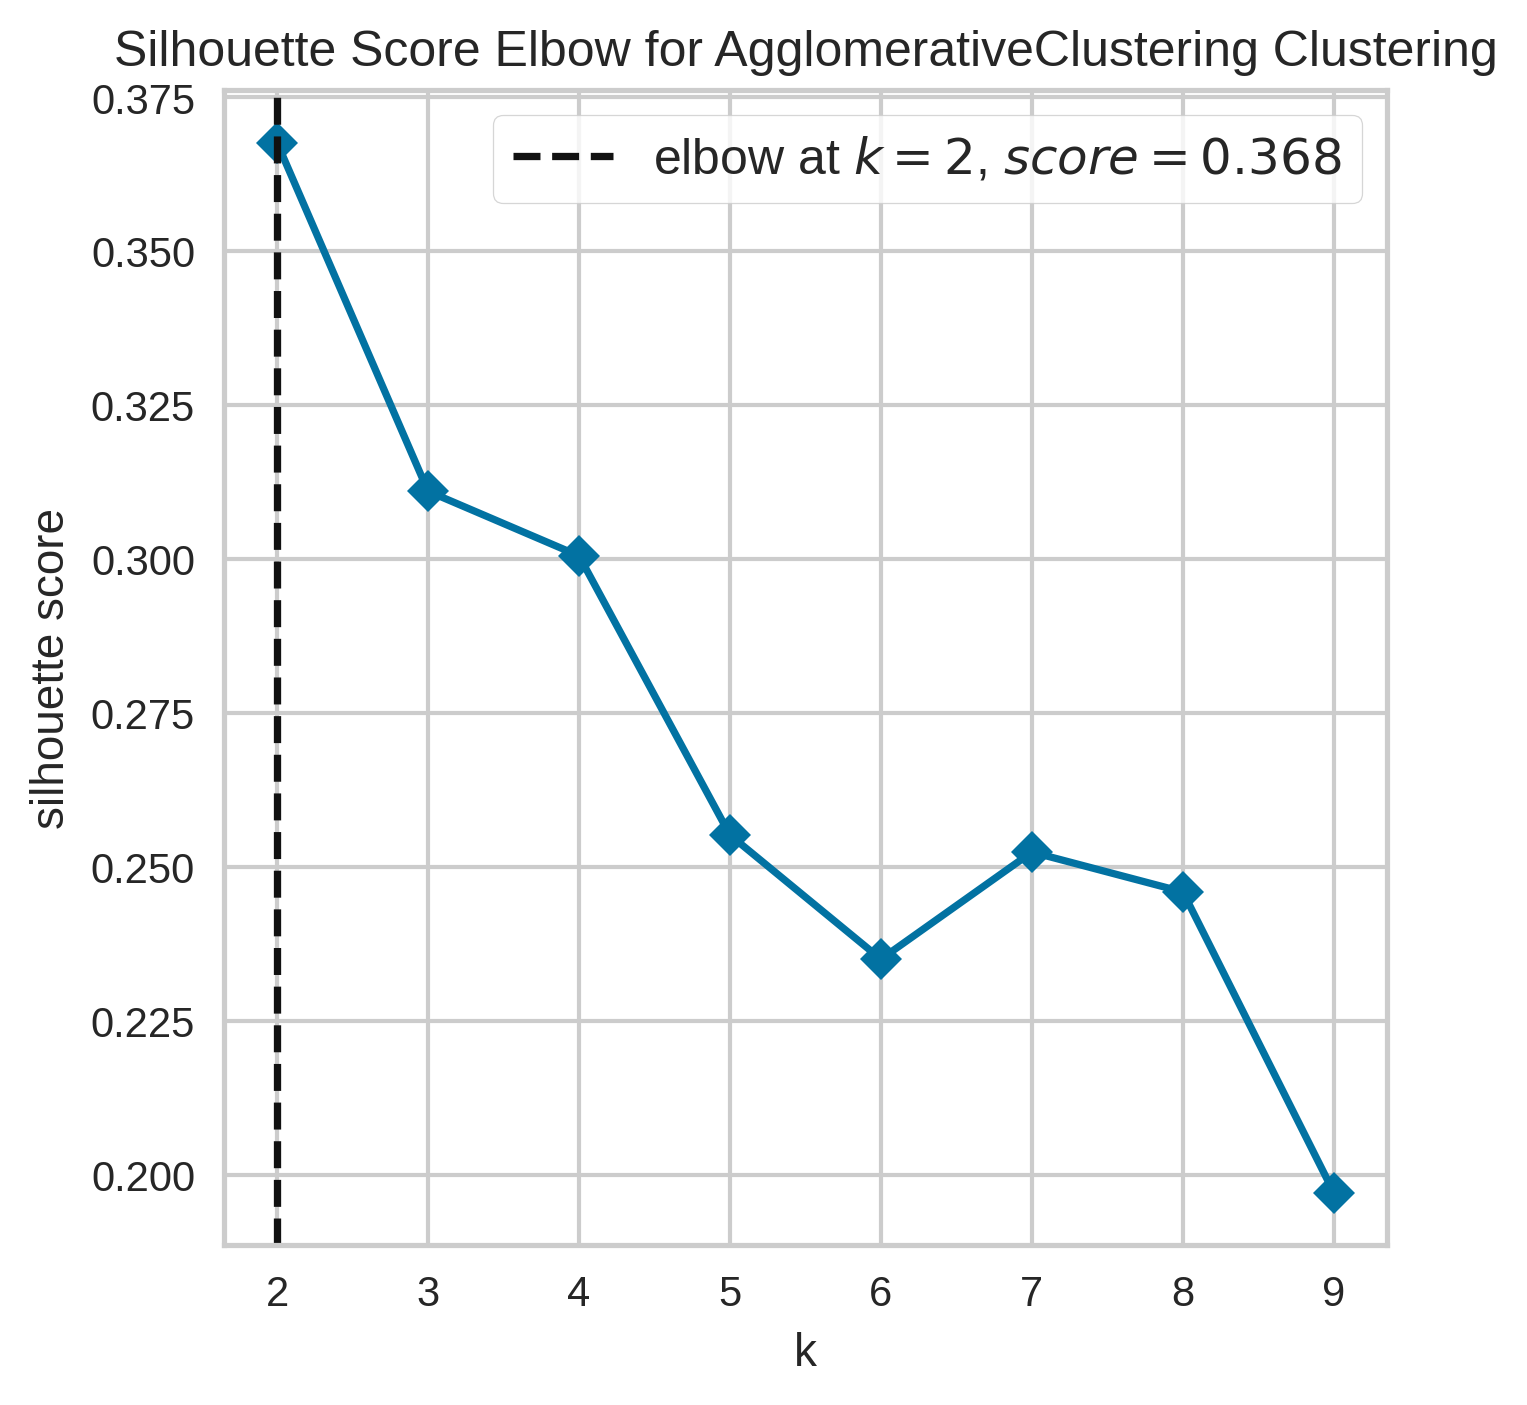

<Axes: title={'center': 'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>

In [75]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering()
fig, ax = plt.subplots(figsize = (5,5), dpi = 300)
elbow = KElbowVisualizer(model, k=(1,10),
                              metric = 'distortion', # mean sum of squared distances to centers
                              timings = False, ax = ax) #
elbow.fit(food_standard)
elbow.show()


'''
# comentario
El gráfico de silueta parte desde 2, dado a que el calculo es mediante
el ratio entre los puntos dentro y cerca del cluster, por lo cual es necesario
que hayan al menos 2 clusters

'''
fig, ax = plt.subplots(figsize = (5,5), dpi = 300)
silueta = KElbowVisualizer(model, k=(2,10),
                              metric = 'silhouette', # mean sum of squared distances to centers
                              timings = False) #
silueta.fit(food_standard)
silueta.show()

Ahora, sabemos que gracias al agrupamiento jerarquico, 2 grupos son identificamos. Así, podemos analizar cuales son estos.

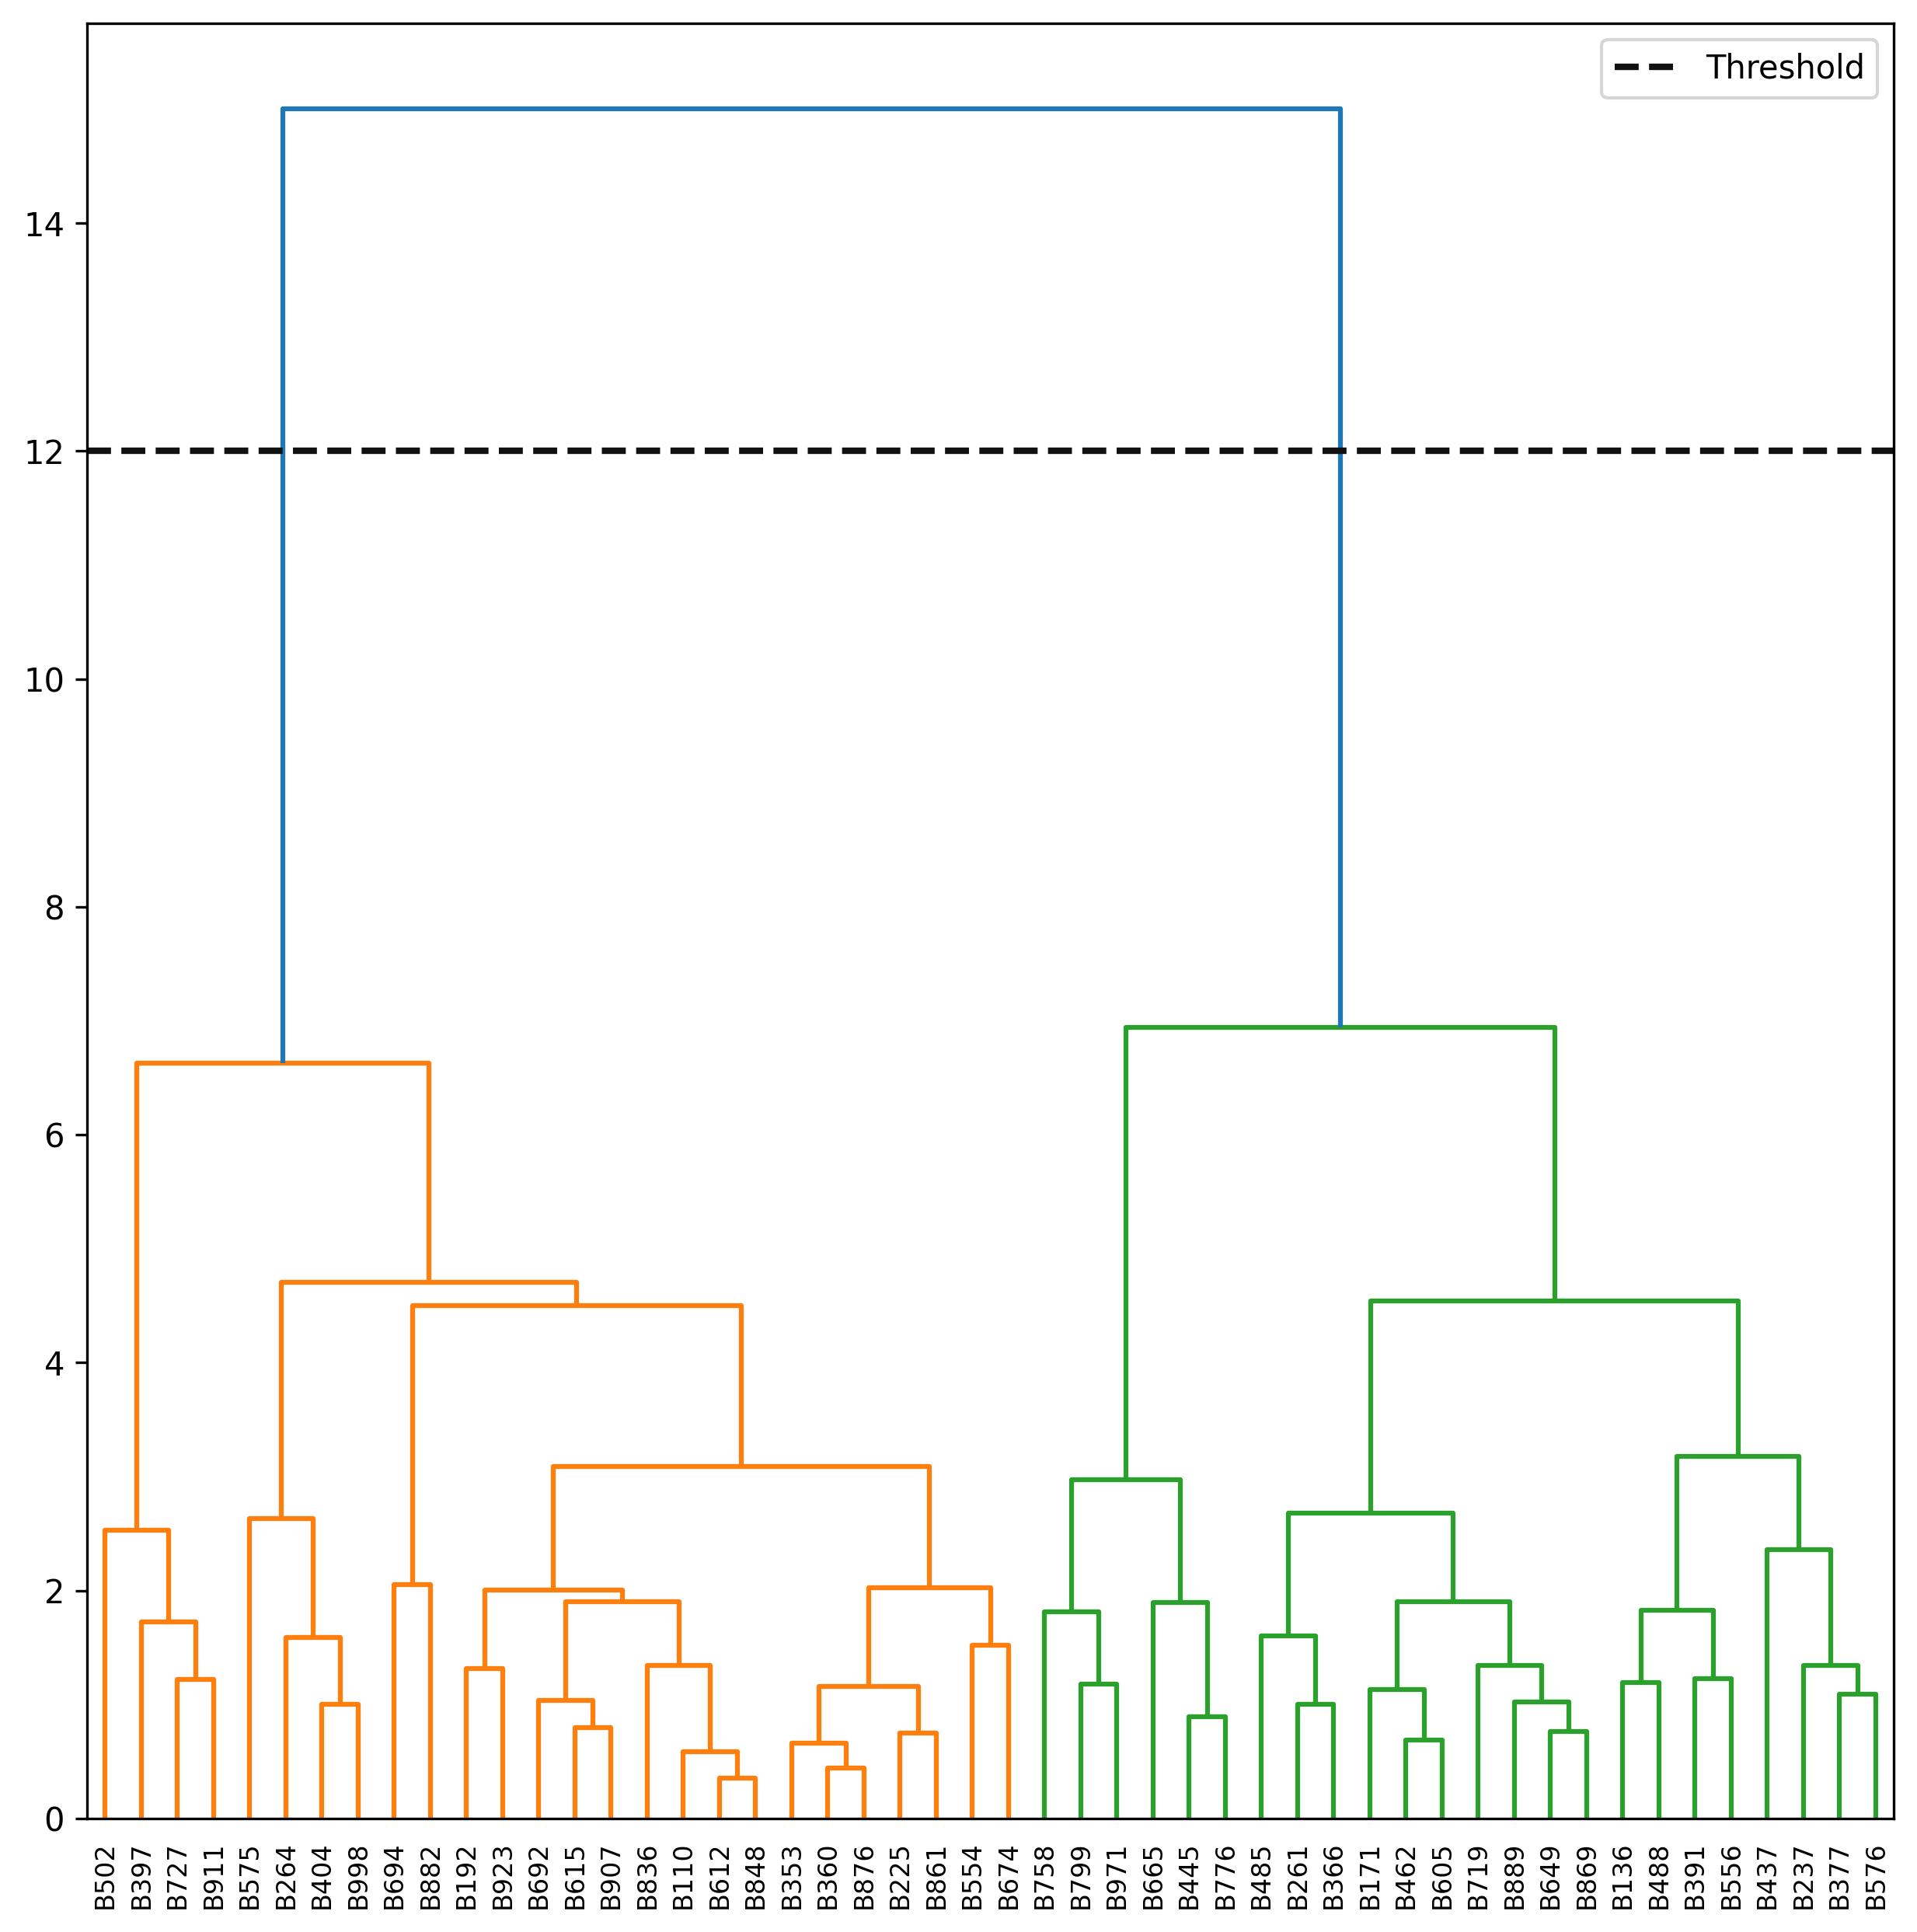

In [93]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

Z = hierarchy.linkage(food_standard, metric = 'euclidean', method='ward')
fig, ax = plt.subplots(figsize = (10,10), dpi = 300)
dendro = hierarchy.dendrogram(Z, ax = ax, labels = food_standard.index, color_threshold=12)
ax.axhline(y=12, color='k', linestyle='--', linewidth = 2, label = 'Threshold')
ax.legend()
plt.show()

[pca] >Cleaning previous fitted model results..
[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


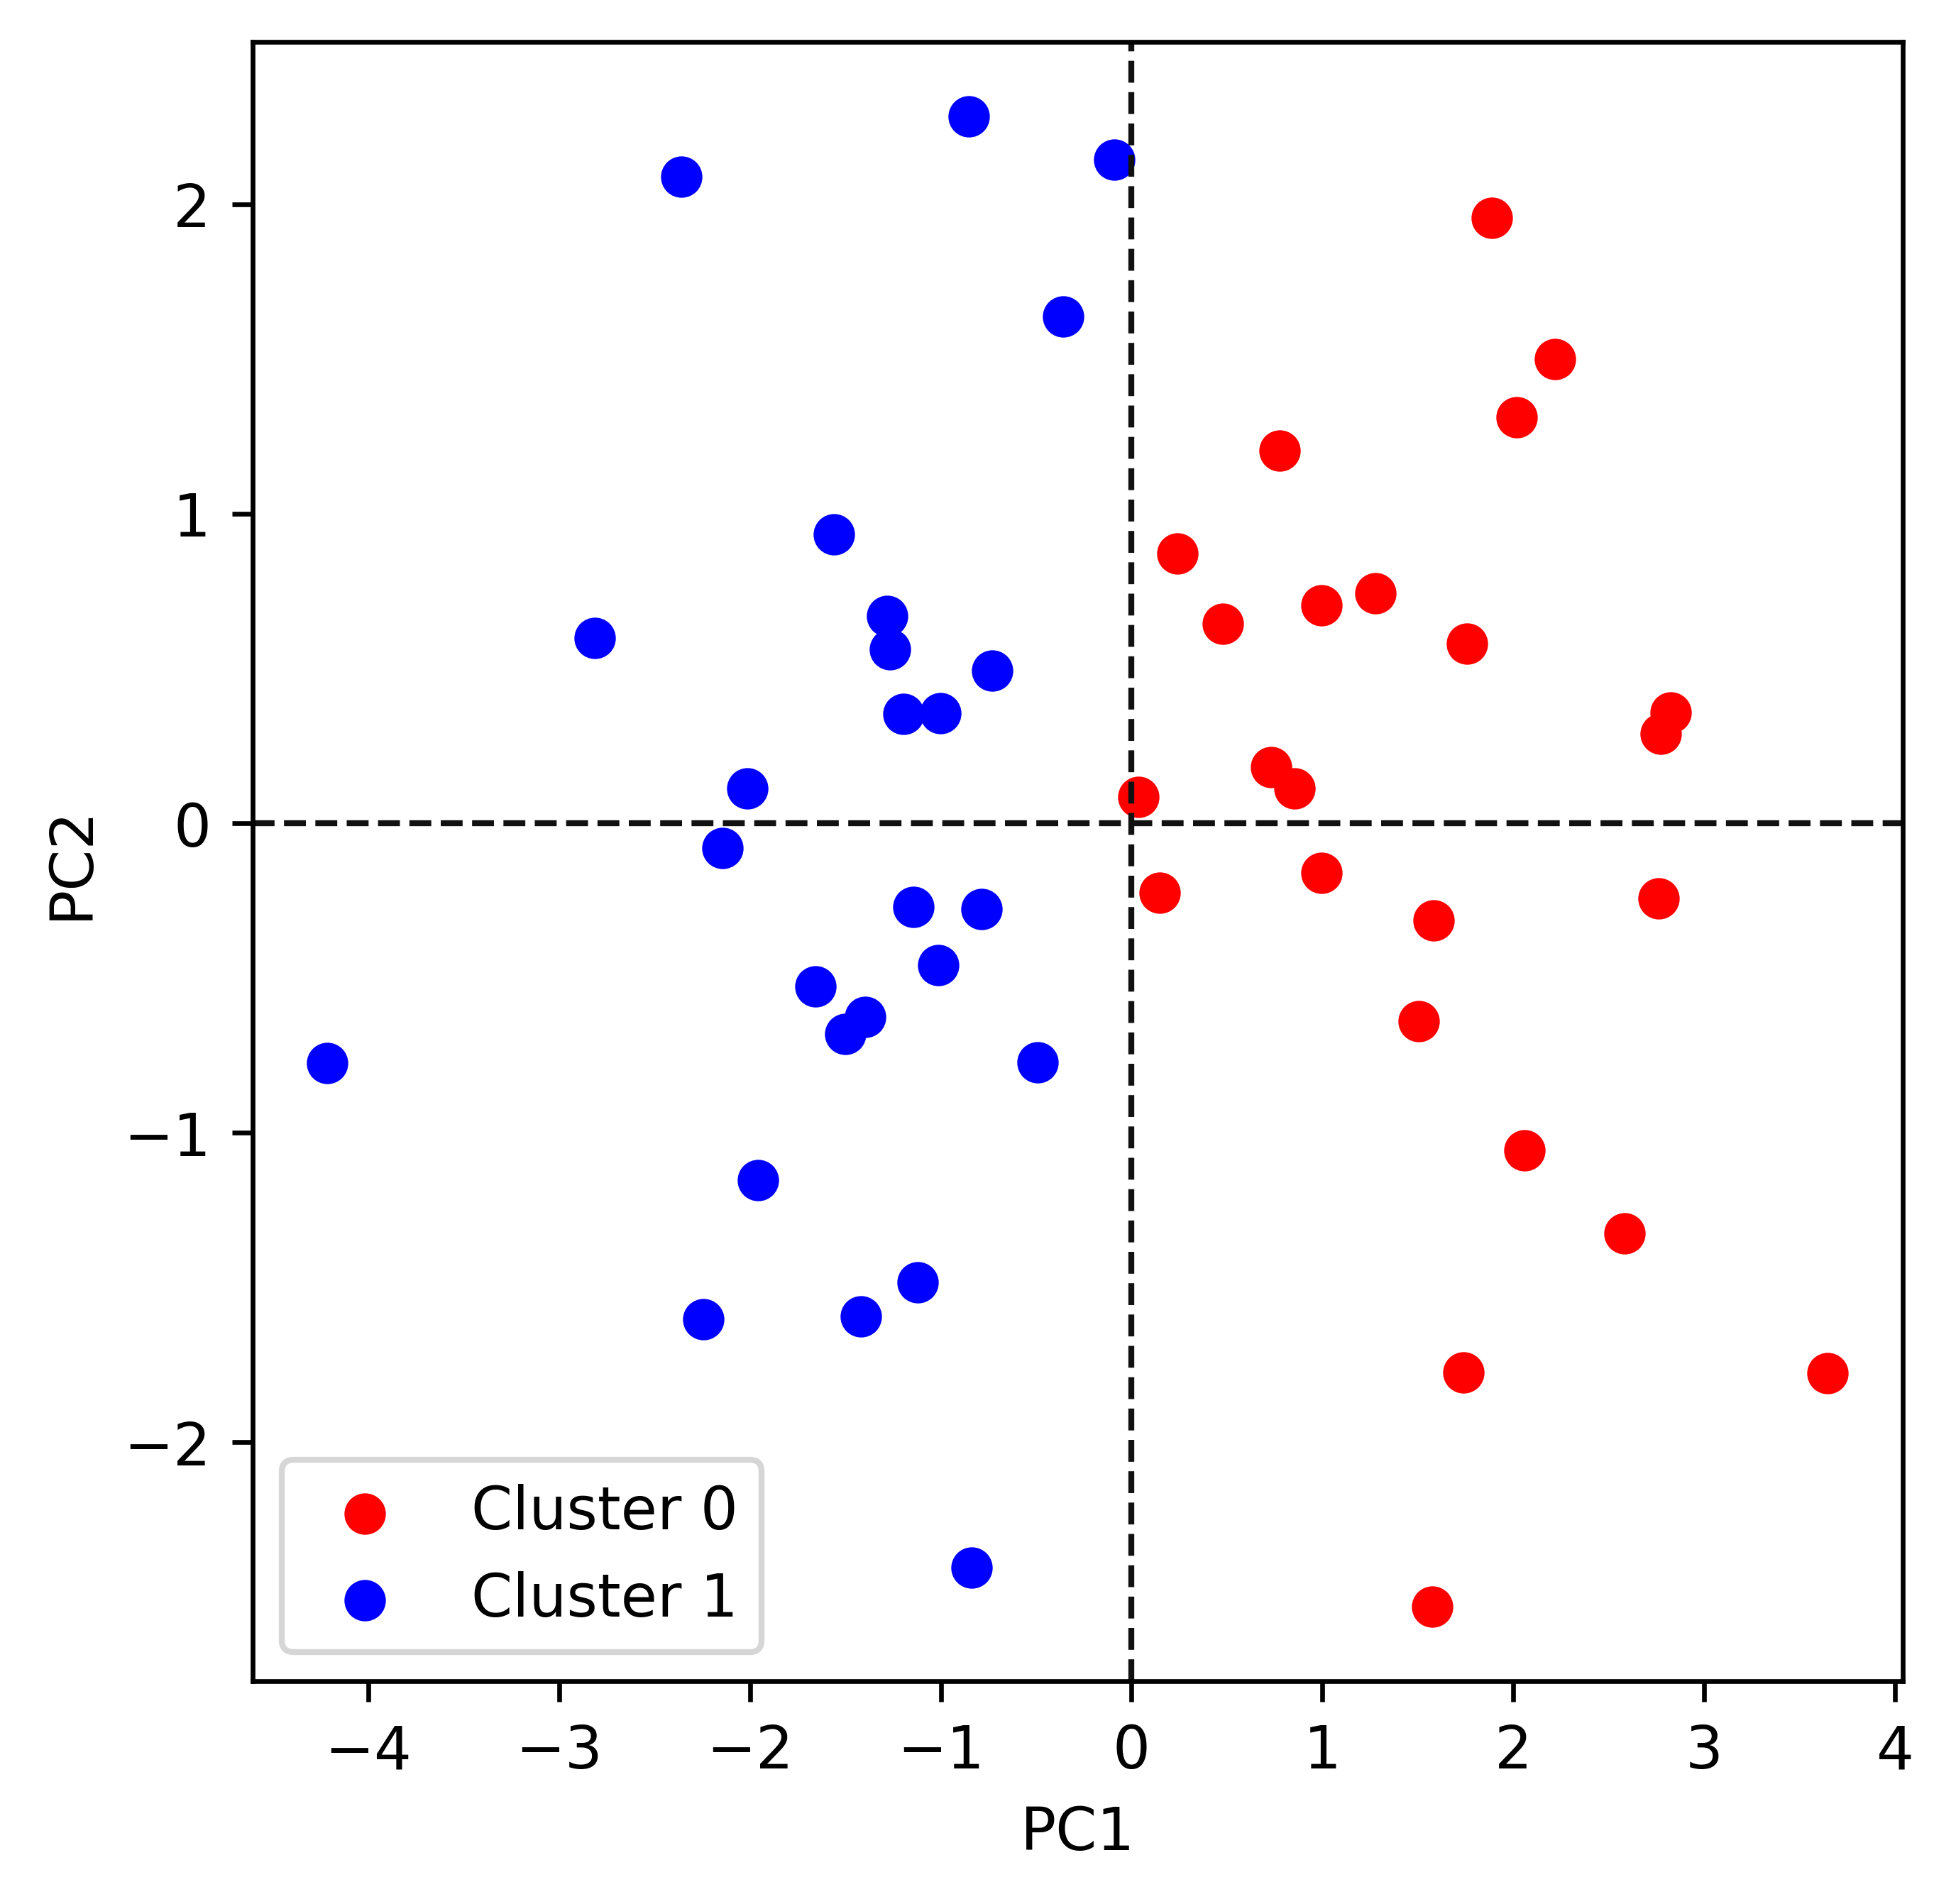

In [99]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
###

food_pca = pd.DataFrame(pca_food_model.fit_transform(food_df)['PC'],
                        columns = ['PC1', 'PC2'],
                        index = food_df.index)
food_pca_cluster = food_pca.copy()
food_pca_cluster['cluster'] = AgglomerativeClustering(
    n_clusters=2).fit_predict(food_standard)

### Graficamos

fig, ax = plt.subplots(figsize = (5,5), dpi = 600)

ax.scatter(food_pca_cluster[food_pca_cluster['cluster'] == 0]['PC1'],
           food_pca_cluster[food_pca_cluster['cluster'] == 0]['PC2'],
           label = 'Cluster 0', c = 'red')
ax.scatter(food_pca_cluster[food_pca_cluster['cluster'] == 1]['PC1'],
           food_pca_cluster[food_pca_cluster['cluster'] == 1]['PC2'],
           label = 'Cluster 1', c = 'blue')
ax.axhline(y=0, color='k', linestyle='--', linewidth = 1)
ax.axvline(x=0, color='k', linestyle='--', linewidth = 1)
ax.legend()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()


## Agrupamiento k-mean

El agrupamiento k-means, es otro tipo de agrupamiento que permite agrupar puntos mediante  la distancia euclideana, pero ahora mediante la definición de centroides que reflejan la mejor configuración. En grandes rasgos, el algoritmo busca minimizar la distancia dentro de los clusters, mientras se maximiza la distancia entre los clusters.

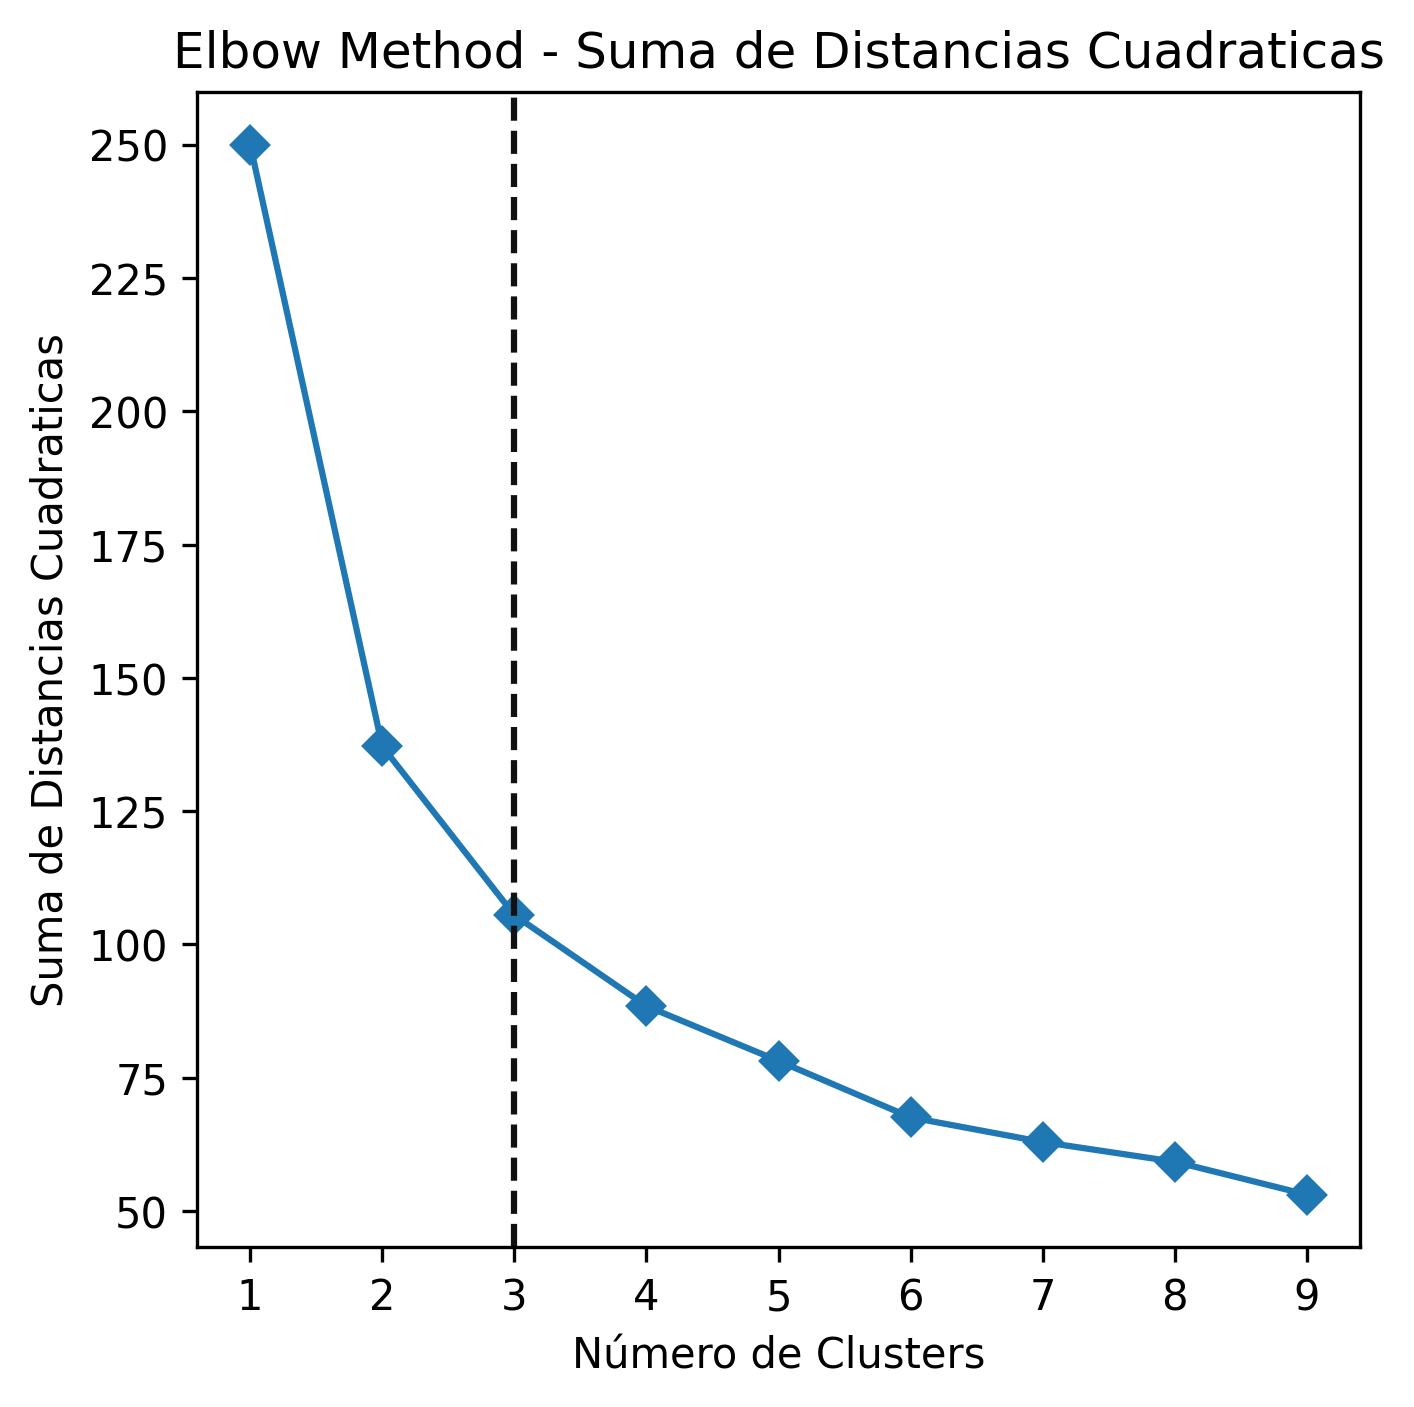

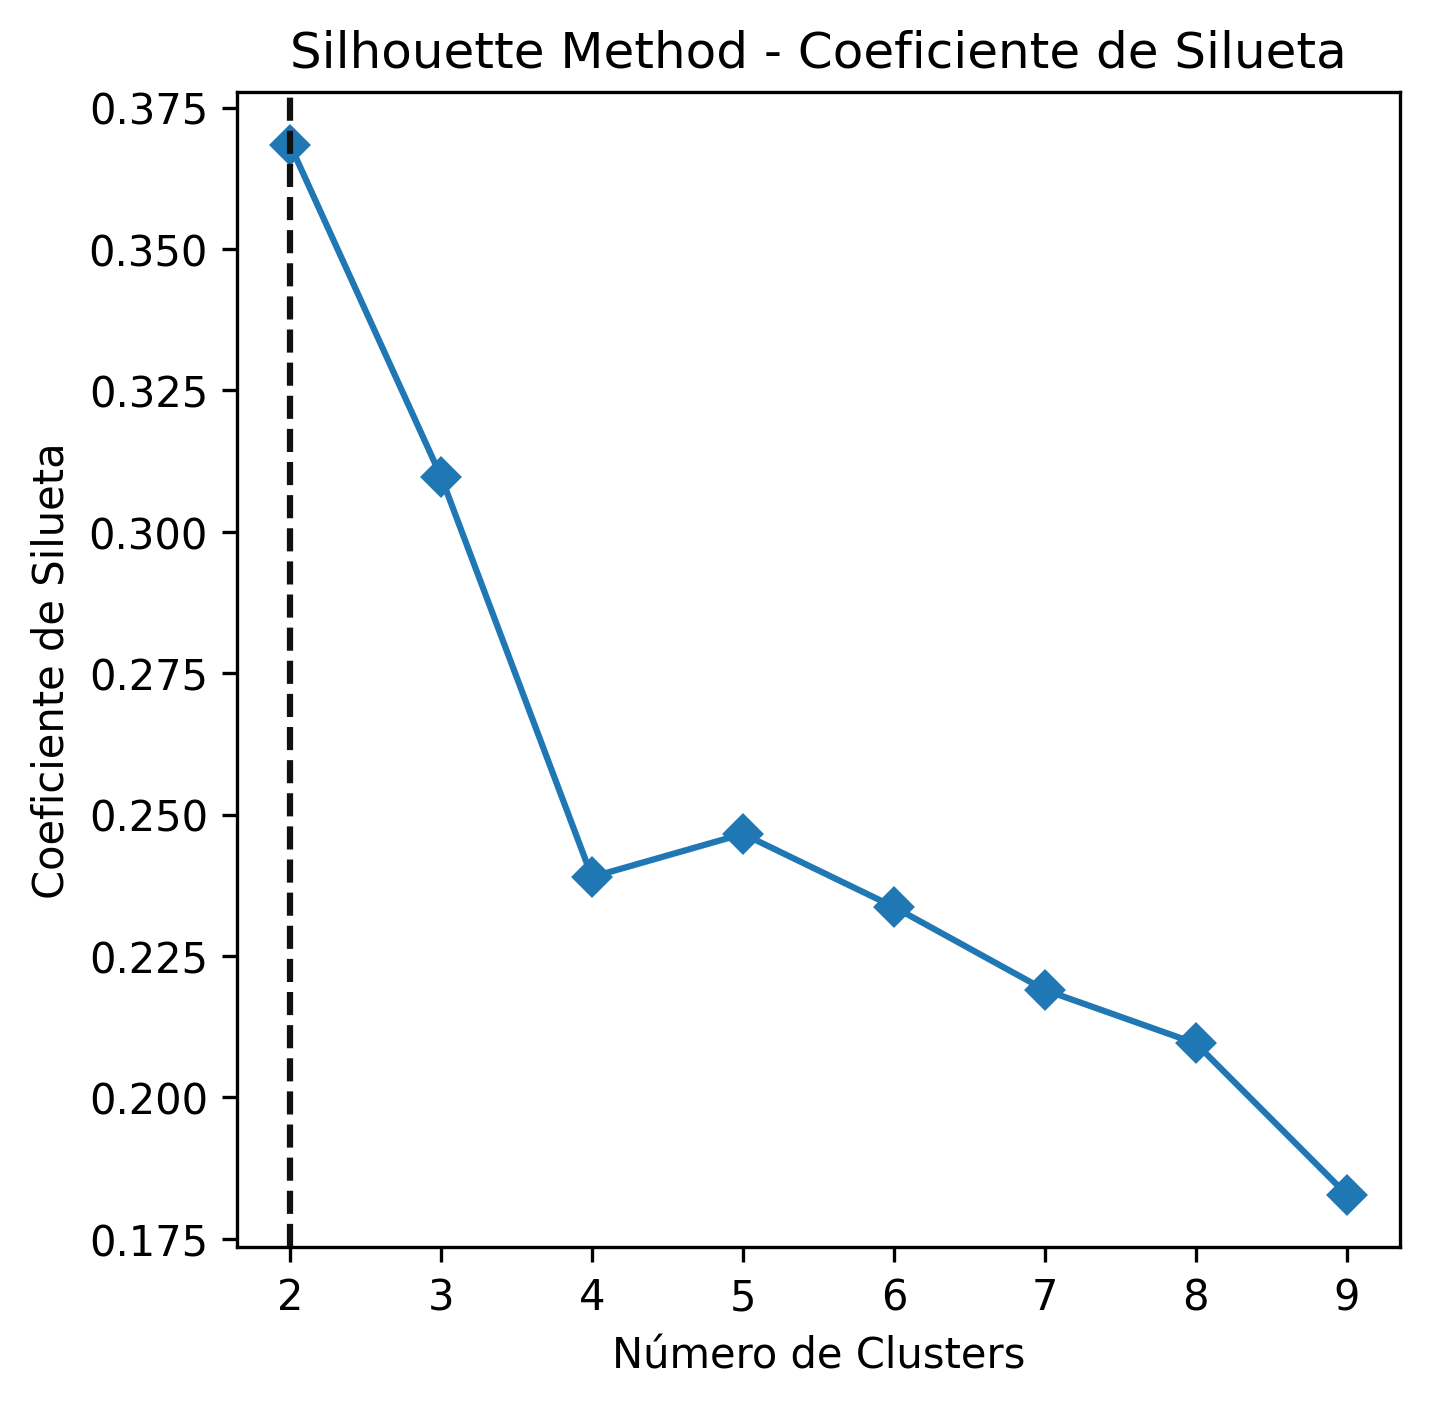

In [104]:
# Analisis de K-mean
from sklearn.cluster import KMeans
np.random.seed(42)
fig, ax = plt.subplots(figsize = (5,5), dpi = 300)
model = KMeans(init = 'random')
elbow = KElbowVisualizer(model, k=(1,10),
                              metric = 'distortion', # mean sum of squared distances to centers
                              timings = False, ax = ax) #
elbow.fit(food_standard)

ax.set_title('Elbow Method - Suma de Distancias Cuadraticas')
ax.set_xlabel('Número de Clusters')
ax.set_ylabel('Suma de Distancias Cuadraticas')
plt.show()

fig, ax = plt.subplots(figsize = (5,5), dpi = 300)
silueta = KElbowVisualizer(model, k=(2,10),
                              metric = 'silhouette', # mean sum of squared distances to centers
                              timings = False, ax = ax) #
silueta.fit(food_standard)
ax.set_title('Silhouette Method - Coeficiente de Silueta')
ax.set_xlabel('Número de Clusters')
ax.set_ylabel('Coeficiente de Silueta')
plt.show()



In [105]:
def optimalK(data, maxClusters):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    ---
    referencia:
    https://www.kaggle.com/code/mallikarjunaj/gap-statistics
    """
    nrefs=3
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf_list = [] # Initialize as a list
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):

            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)

            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)

            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)

        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap

        # Append data as a dictionary to the list
        resultsdf_list.append({'clusterCount': k, 'gap': gap})

    # Create DataFrame outside the loop
    resultsdf = pd.DataFrame(resultsdf_list)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

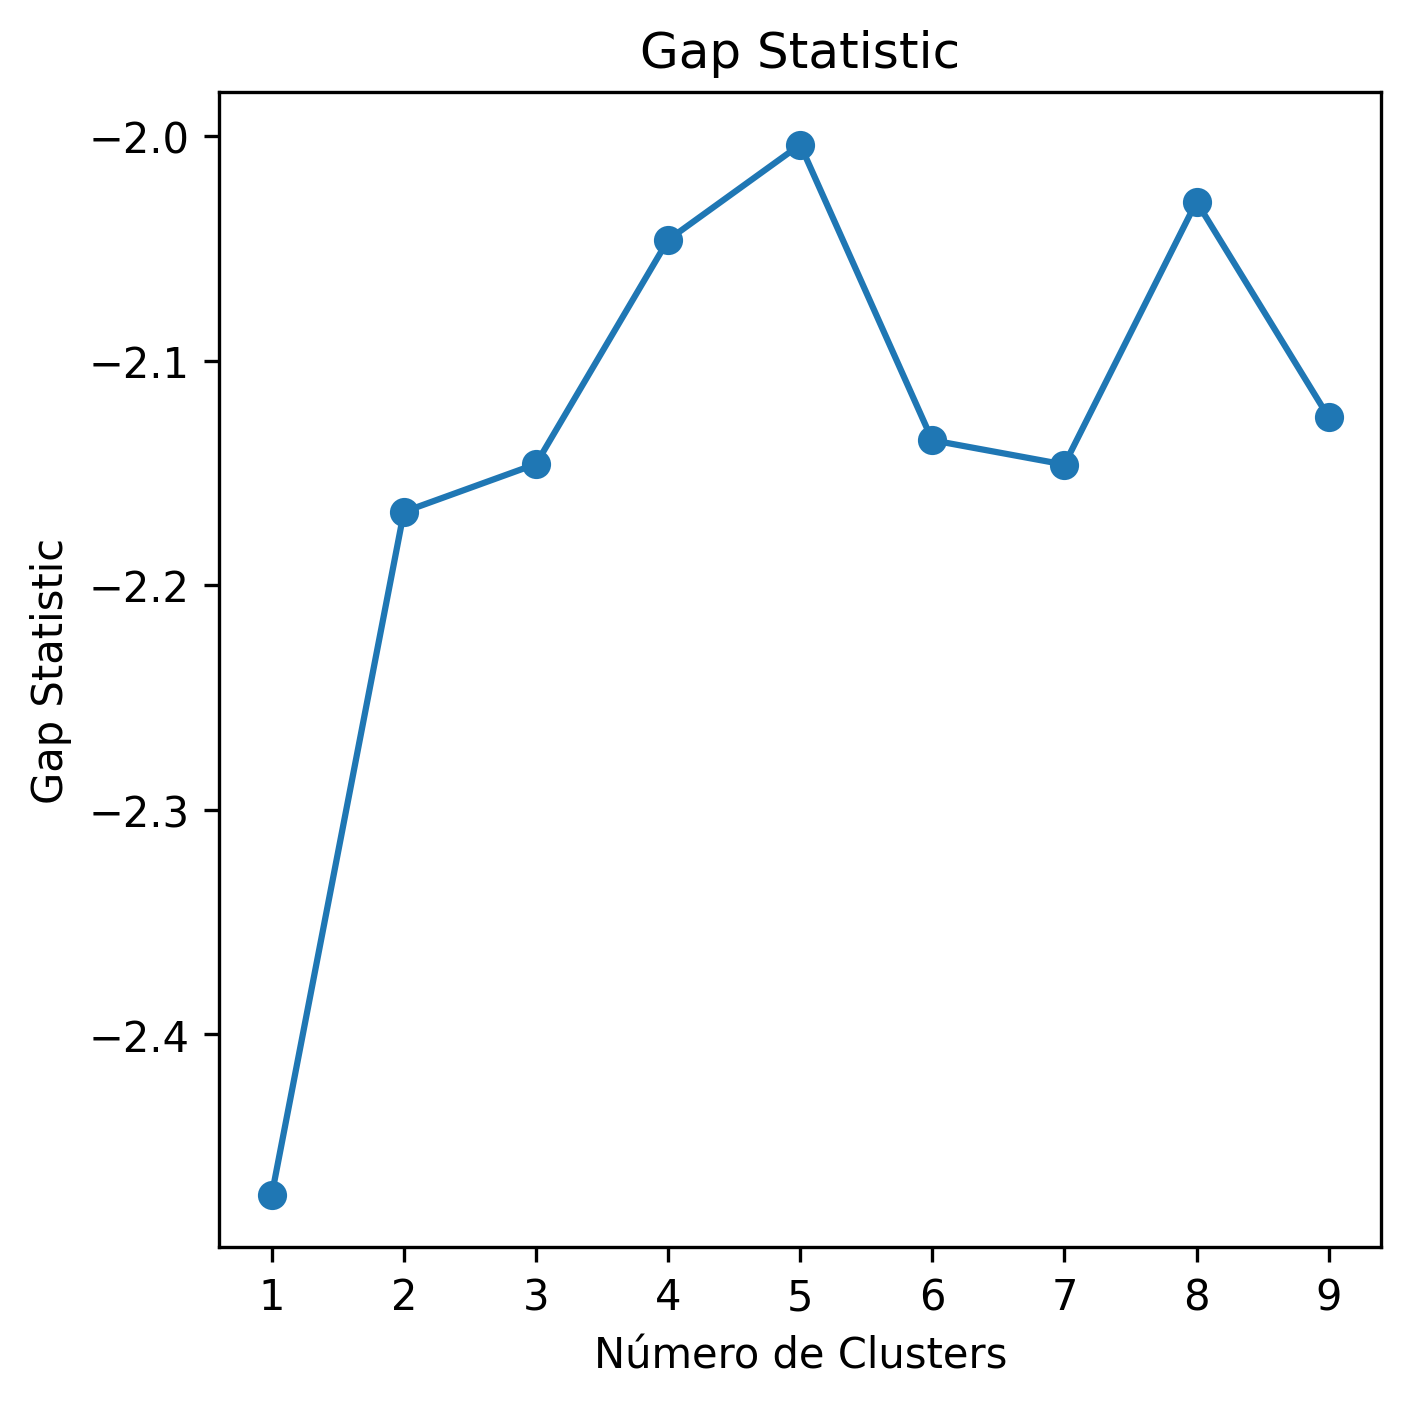

In [109]:
_, results = optimalK(food_standard, 10)

fig, ax = plt.subplots(dpi = 300, figsize = (5,5))

ax.plot(results['clusterCount'], results['gap'], marker = 'o')
ax.set_xlabel('Número de Clusters')
ax.set_ylabel('Gap Statistic')
ax.set_title('Gap Statistic')
# ax.axhline(y=0, color='k', linestyle='--', linewidth = 1)
plt.show()

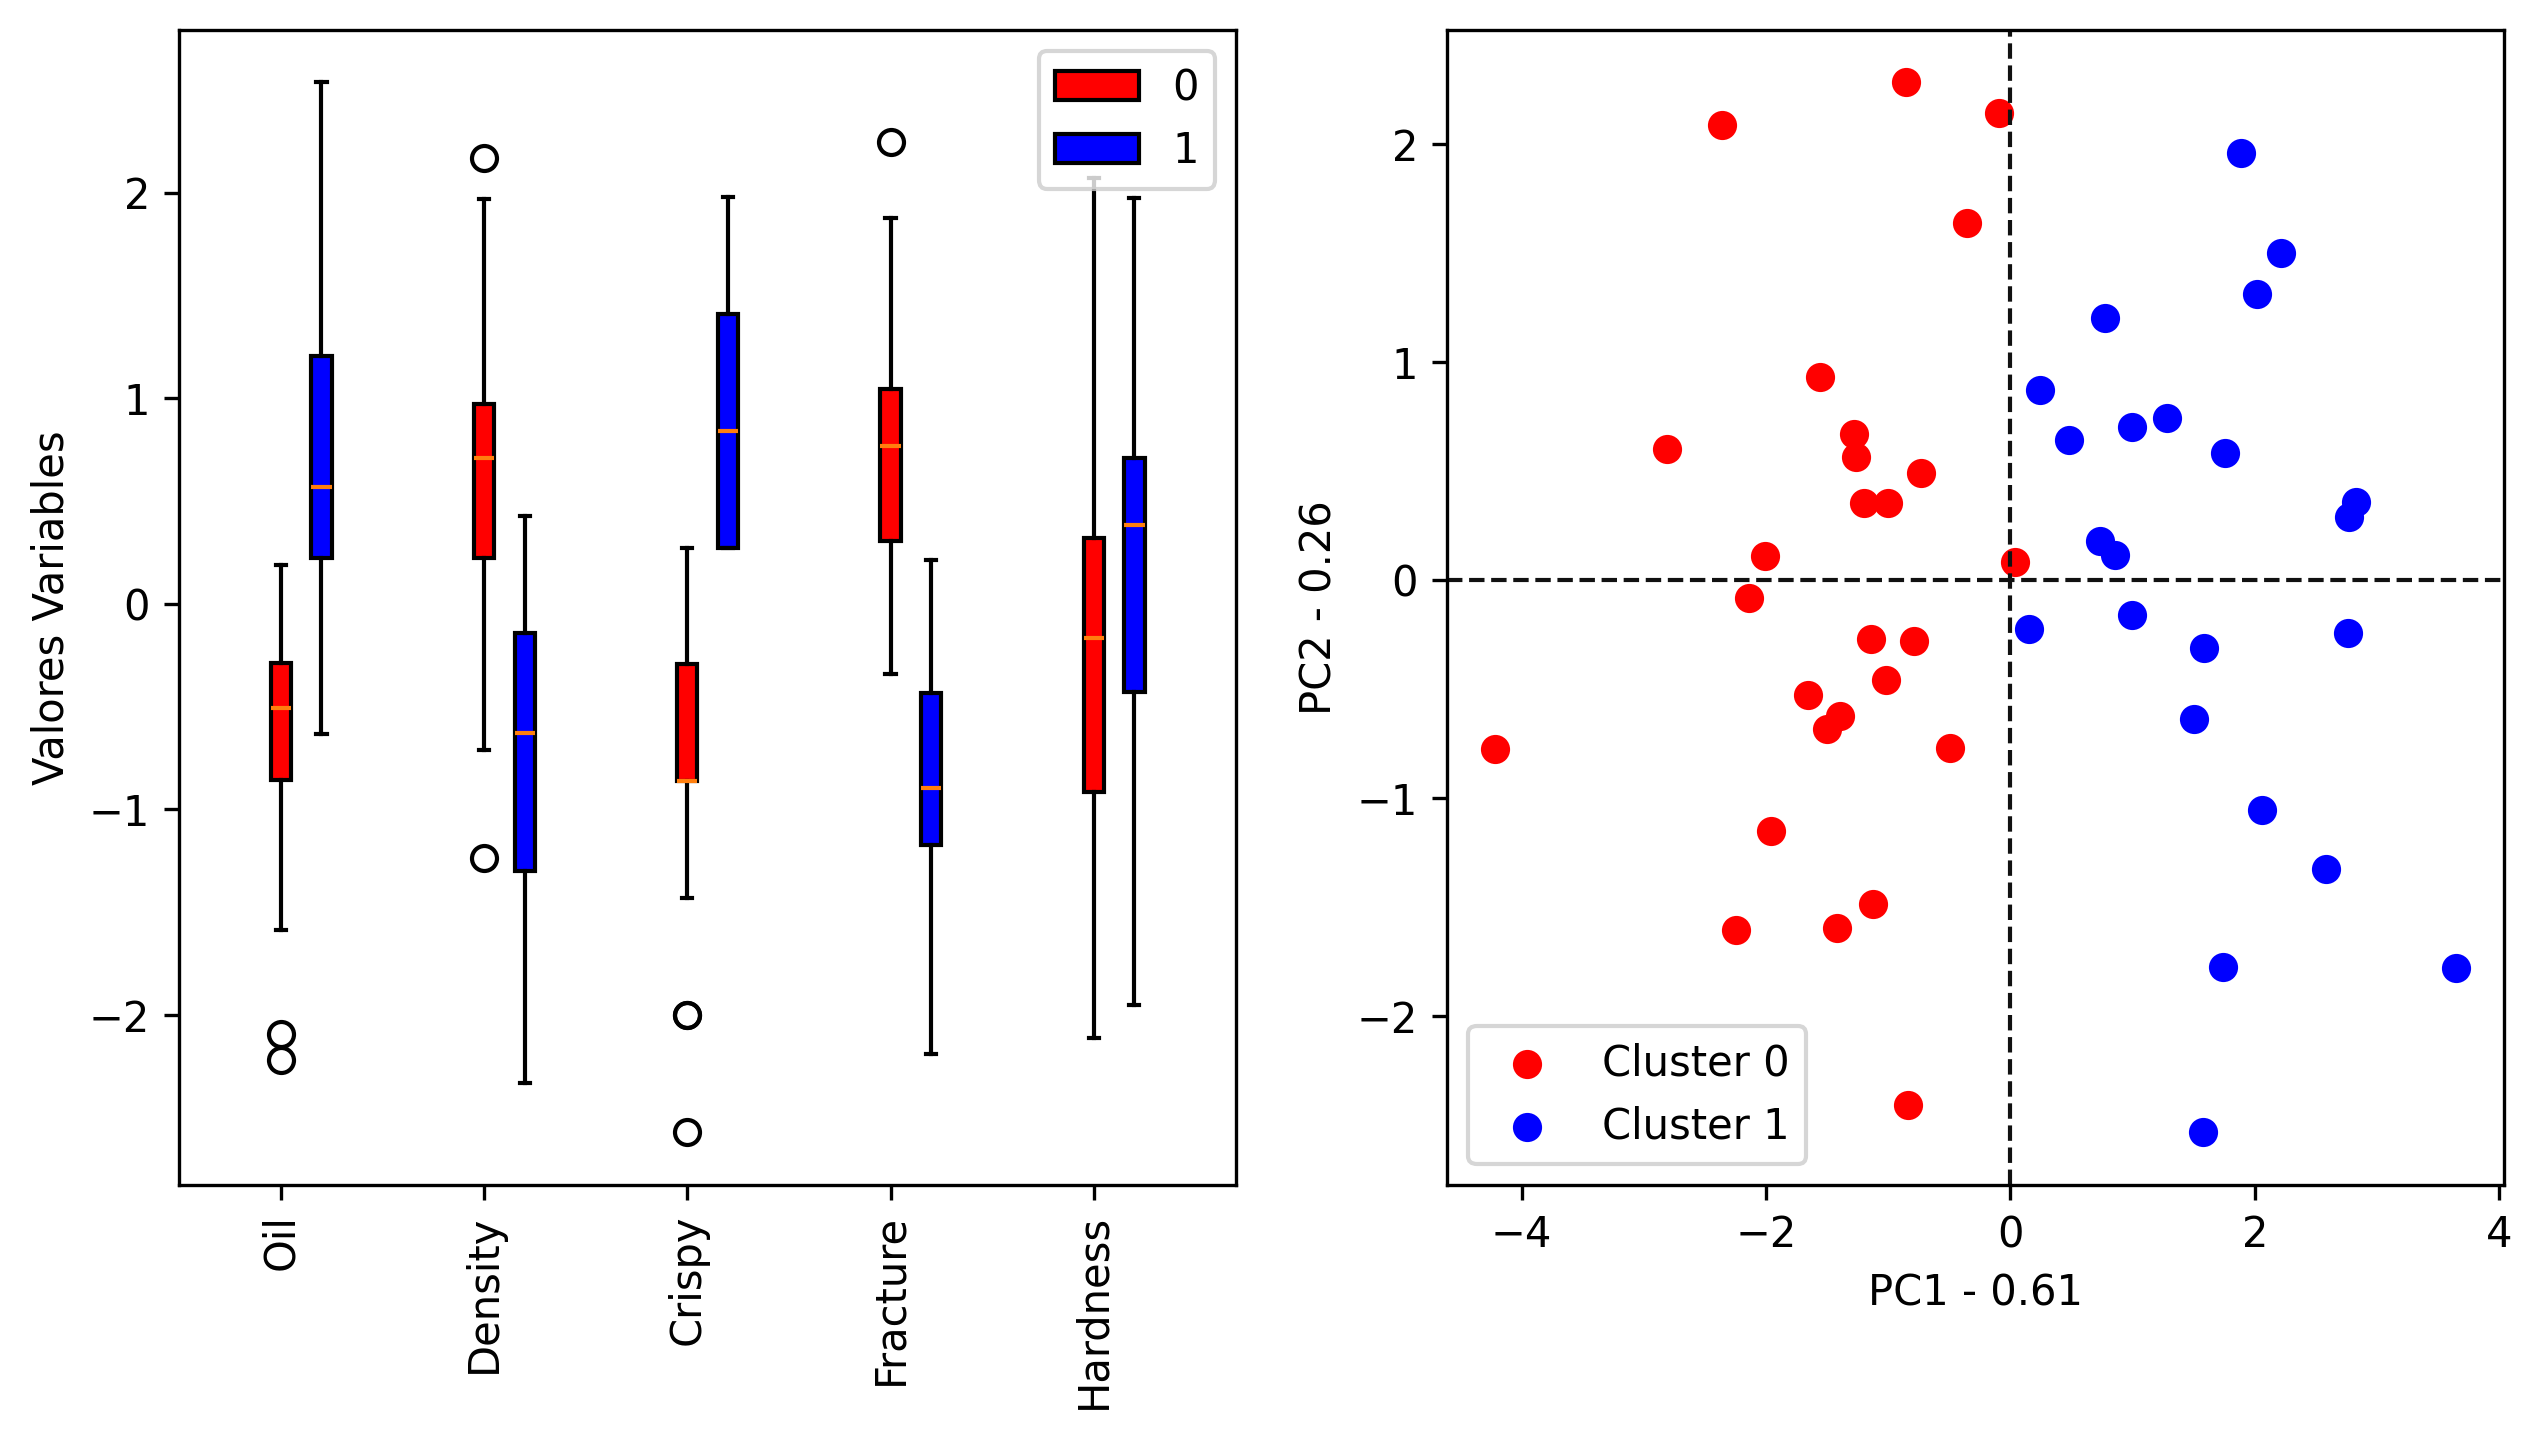

In [161]:
# Graficamos
### K = 2

kmeans_model = KMeans(n_clusters = 2)
kmeans_model.fit(food_standard)
food_df_cluster = food_df.copy()
food_df_cluster['cluster'] = kmeans_model.predict(food_standard)

food_pca_cluster = food_pca.copy()
food_pca_cluster['cluster'] = kmeans_model.predict(food_standard)


###
fig, ax = plt.subplots(1,2, dpi = 300, figsize = (10,5))
food_standard['cluster'] = kmeans_model.predict(food_standard)
d = 0
i = 0
cluster_col = {
    0: 'red',
    1: 'blue'
}
for col in food_standard.columns[:-1]:
    for clu in food_standard['cluster'].unique():
        data_clu = food_standard[food_standard['cluster'] == clu][col]
        ax[0].boxplot(
            data_clu, positions = [i+d],
            widths = 0.1,
            patch_artist = True,
            boxprops = {'facecolor':cluster_col[clu]},
            tick_labels = None,
            label = str(clu) if i == 0 else None
        )
        d += 0.2
    d = 0
    i += 1

ax[0].set_xticks(np.arange(0, i))
ax[0].set_xticklabels(food_standard.columns[:-1], rotation = 90)
ax[0].legend(loc = 'upper right')
ax[0].set_ylabel('Valores Variables')
ax[1].scatter(food_pca_cluster[food_pca_cluster['cluster'] == 0]['PC1'],
           food_pca_cluster[food_pca_cluster['cluster'] == 0]['PC2'],
           label = 'Cluster 0', c = 'red')
ax[1].scatter(food_pca_cluster[food_pca_cluster['cluster'] == 1]['PC1'],
           food_pca_cluster[food_pca_cluster['cluster'] == 1]['PC2'],
           label = 'Cluster 1', c = 'blue')
ax[1].axhline(y=0, color='k', linestyle='--', linewidth = 1)
ax[1].axvline(x=0, color='k', linestyle='--', linewidth = 1)
ax[1].legend()
variance_ratio = data['variance_ratio']
ax[1].set_xlabel(f'PC1 - {variance_ratio[0]:.2f}')
ax[1].set_ylabel(f'PC2 - {variance_ratio[1]:.2f}')


plt.show()
